For FGDC and ISO, can we identify the age of the metadata record?

What's the oldest? What's the age distribution?

For this, we're going to access the RDS.

for iso, on root node:

```
<gmd:dateStamp>
        <gco:Date>2015-09-10</gco:Date>
    </gmd:dateStamp>
```



for fgdc:
```
metainfo/metd (released)
metainfo/metrd (reviewed)
```

In [1]:
import json as js  # name conflict with sqla
import sqlalchemy as sqla
from sqlalchemy.orm import sessionmaker
from sqlalchemy.dialects.postgresql import *
from sqlalchemy import and_
from semproc.xml_utils import *
from mpp.models import Response
from datetime import datetime
from lxml import etree

In [2]:
def _convert_date(datestr):
    # convert the 4-8 char to an iso date and deal with unknowns
    if datestr.lower() in ['unknown', 'none']:
        return ''

    year = datestr[:4]
    month = datestr[4:6] if len(datestr) > 4 else '1'
    day = datestr[6:] if len(datestr) > 6 else '1'
    try:
        d = datetime(int(year), int(month), int(day))
        return d.isoformat()
    except:
        return ''

In [3]:
# load the postgres connection file
with open('../local/big_rds.conf', 'r') as f:
    conf = js.loads(f.read())

# our connection
engine = sqla.create_engine(conf.get('connection'))
Session = sessionmaker()
Session.configure(bind=engine)
session = Session()

In [13]:
# just for resets
session.rollback()

In [4]:
sketchy_sql = '''with i
as (
    select d.response_id, jsonb_array_elements(d.identity::jsonb) ident
    from identities d
    where d.identity is not null
)

select r.id, r.source_url, r.source_url_sha, r.cleaned_content, i.ident->'protocol' as protocol
from responses r join i on i.response_id = r.id
where i.ident->>'protocol' = 'FGDC' or i.ident->>'protocol' = 'ISO'
limit %s
offset %s;
'''



In [6]:
timestamps = []
LIMIT=500
for i in xrange(0, 46000, LIMIT):
    sql = sketchy_sql % (LIMIT, i)
    result = session.execute(sql)
    for r in result:
    #     print r['source_url']
        try:
            xml = etree.fromstring(r['cleaned_content'].encode('utf-8'))
        except:
            print 'xml fail', r['id']
            continue

        if r['protocol'] == 'ISO':
            # see if we catch dates in ds mi/md sets, etc
            md_dates = extract_items(xml, ['//*', 'dateStamp', 'Date'])
        elif r['protocol'] == 'FGDC':
            md_date = extract_item(xml, ['//*', 'metainfo', 'metd'])
            try:
                md_dates = [_convert_date(md_date)]
            except:
                md_dates = []

        if not md_dates:
            continue

        timestamps += [(r['id'], r['source_url'], m) for m in md_dates]
    

xml fail 145560
xml fail 183293
xml fail 196865
xml fail 219701
xml fail 223566
xml fail 252783
xml fail 307810
xml fail 351247
xml fail 402936
xml fail 453490
xml fail 503992
xml fail 539074
xml fail 563466
xml fail 576196
xml fail 653347
xml fail 667256
xml fail 721563
xml fail 722226


In [7]:
len(timestamps)

40677

In [10]:
with open('outputs/metadata_age.csv', 'w') as f:
    f.write('id,url,date\n')
    f.write(
        '\n'.join(
            ['{0},{1},{2}'.format(m[0], m[1], m[2]) for m in timestamps]
        )
    )

In [13]:
min(timestamps, key=lambda x: x[2] if '1900-01-01' not in x[2] and x[2] else datetime.now().isoformat())

(590037,
 u'http://earthquake.usgs.gov/earthquakes/shakemap/ak/shake/1964_se/download/metadata.xml',
 '1964-03-27T00:00:00')

So. 1964. We're going to need some charts here.

In [34]:
%matplotlib inline
import pandas as pd
import dateutil.parser as parser

with open('outputs/metadata_age.csv', 'r') as f:
    data = f.readlines()
data = [d.strip().split(',') for d in data[1:] if d]
subsetted = []
for i, u, d in data:
    if not d:
        continue
    try:
        nd = parser.parse(d)
        if nd.year > 1800 and nd.year < 2100:
            subsetted.append((i, u, nd.isoformat()))
    except:
        continue

df = pd.DataFrame(subsetted, columns=['id', 'url', 'date'])

# df = pd.read_csv('outputs/metadata_age.csv', header=0, parse_dates=[2])

In [29]:
df

,id,url,date
0,137653,http://www.ngdc.noaa.gov/metadata/published/NO...,2014-03-18T06:00:00
1,137661,http://www.usgs.gov/science/iso.php?cite=1628,2012-09-05T00:00:00
2,137687,http://ec.gc.ca/data_donnees/data/ice/conditio...,2011-07-21T00:00:00
3,137688,http://coastwatch.pfeg.noaa.gov/erddap/metadat...,2015-08-04T00:00:00
4,137692,http://www.usgs.gov/science/iso.php?cite=1732,2008-04-09T00:00:00
5,137719,http://geoport.whoi.edu/thredds/iso/MOBILE_BAY...,2015-08-12T00:00:00
6,137746,http://coastwatch.pfeg.noaa.gov/erddap/metadat...,2015-08-05T00:00:00
7,137755,http://coast.noaa.gov/data/Documents/Metadata/...,2015-02-10T00:00:00
8,137775,http://www.ngdc.noaa.gov/metadata/published/NO...,2014-08-15T06:00:00
9,137831,http://www.ncddc.noaa.gov/oer-waf/ISO/Resolved...,2014-10-21T00:00:00


In [35]:
df.convert_objects(convert_dates='coerce')
df['date'] = df['date'].astype("datetime64")
# df.date = df.date.astype("datetime64")
df.dtypes

id              object
url             object
date    datetime64[ns]
dtype: object

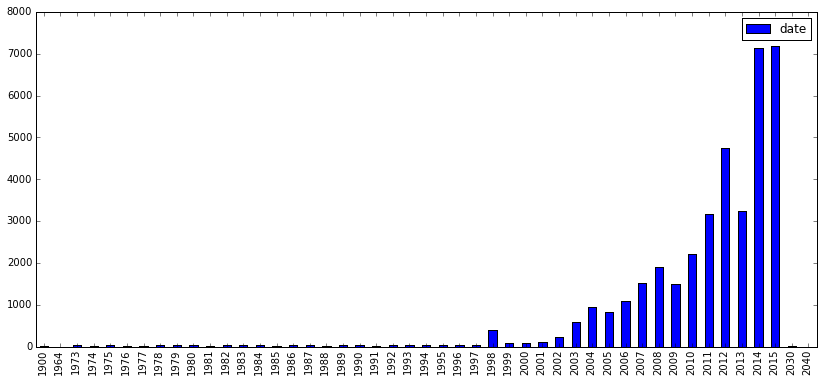

In [42]:

df[['date']].groupby(df['date'].dt.year).count().plot(kind="bar", figsize=(14, 6))

In [43]:
df[['date']].groupby(df['date'].dt.year).count()

,date
1900,5
1964,1
1973,32
1974,21
1975,29
1976,28
1977,26
1978,34
1979,30
1980,34
